In [1]:
import torch
from torch import nn
from torchvision import models, transforms

In [2]:
gpu = torch.cuda.is_available()

if not gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available')

CUDA is available


In [3]:
# in PyTorch implementation flattenning is done in the forward pass, but we need it as a separate layer
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)

In [4]:
# load resnet50
model = models.resnet50(pretrained=True)

# get feature extractor and classifier
features_fn = nn.Sequential(*list(model.children())[:-2])
classifier_fn = nn.Sequential(*(list(model.children())[-2:-1] + [Flatten()] + list(model.children())[-1:]))

print("feature extractor :")
print(features_fn)
print("\nclassifier :")
print(classifier_fn)

feature extractor :
Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [5]:
# it will notify all your layers that you are in eval mode
# batchnorm or dropout layers will work in eval mode instead of training mode
model = model.eval()

if gpu:
    model = model.cuda()

In [6]:
read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    lambda x: x.convert('RGB'),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    lambda x: torch.unsqueeze(x, 0) # unsqueze() inserts a new dimension in the position received by the argument
])

In [7]:
def get_class_name(c):
    labels = np.loadtxt('./synset_words.txt', str, delimiter='\t')
    return ' '.join(labels[c].split(',')[0].split()[1:])

In [8]:
def GradCAM(img, c, features_fn, classifier_fn):
    feats = features_fn(img.cuda()) # [1, 2048, 7, 7]
    _, N, H, W = feats.size()
    out = classifier_fn(feats)
    c_score = out[0, c] # output value of class c

    grads = torch.autograd.grad(c_score, feats) # get gradient map (grads[0][0])
                                                # [2048, 7, 7]
    w = grads[0][0].mean(-1).mean(-1) # GAP of grads
                                      # [2048]

    sal = torch.matmul(w, feats.view(N, H*W)) # feats.view(N, H*W) -> [2048, 49]
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal

In [9]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

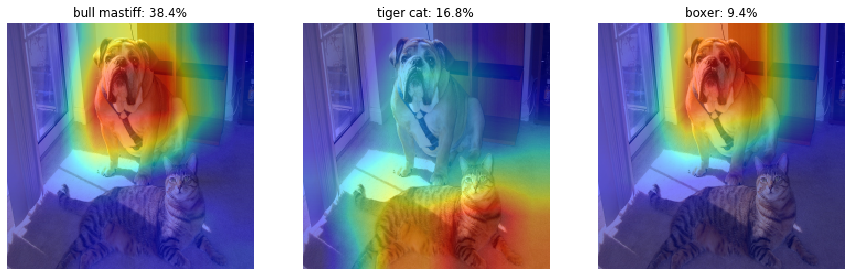

In [10]:
img_path = './catdog.png'
img_tensor = read_tensor(img_path)

pp, cc = torch.topk(nn.Softmax(dim=1)(model(img_tensor.cuda())), 3)

plt.figure(figsize=(15, 5))
for i, (p, c) in enumerate(zip(pp[0], cc[0])):
    plt.subplot(1, 3, i+1)
    sal = GradCAM(img_tensor, int(c), features_fn, classifier_fn)
    img = Image.open(img_path)
    sal = Image.fromarray(sal)
    sal = sal.resize(img.size, resample=Image.LINEAR)

    plt.title('{}: {:.1f}%'.format(get_class_name(c), 100*float(p)))
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(np.array(sal), alpha=0.5, cmap='jet')
plt.show()